In [29]:
import pennylane as qml
from pennylane import numpy as np

import math

from scipy.optimize import minimize

from matplotlib import pyplot as plt

# Gradient-free `CRP` parameter optimization

## 1. Set up small demo circuit

In [30]:
dev = qml.device("default.qubit", wires=2, shots=None)

@qml.qnode(dev)
def complex_circuit(crx_param):
    # some unparameterized gates
    qml.Hadamard(wires=0)
    qml.RX(1.2, wires=1)
    qml.Hadamard(wires=1)
    qml.CRX(math.pi/2, wires=[1, 0])

    # this is the gate to optimize
    qml.CRX(crx_param, wires=[0, 1])

    # some more unparameterized gates 
    qml.RX(2.3, wires=0)
    qml.CNOT(wires=[1, 0])
    
    # measure qubit 0 in computational basis
    return qml.expval(qml.PauliX(0))

@qml.qnode(dev)
def rx_circuit(rx_param):
    qml.RX(rx_param, wires=0)

    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev)
def crx_circuit(crx_param):
    qml.Hadamard(wires=0)
    qml.CRX(crx_param, wires=[0, 1])

    return qml.expval(qml.PauliZ(1))

circuit = complex_circuit
print(qml.draw(circuit)((0,)))

0: ──H───────────╭RX(1.57)─╭●───────RX(2.30)─╭X─┤  <X>
1: ──RX(1.20)──H─╰●────────╰RX(M0)───────────╰●─┤     
M0 = 
[0]


## 2. Reconstruct cost function

In [31]:
theta = 0

# measure function at six chosen points
y_0 = circuit(theta + 0)
print(f"y_0={y_0}")

y_pi = circuit(theta + math.pi)
print(f"y_pi={y_pi}")

y_32pi = circuit(theta + 3 / 2 * math.pi)
print(f"y_3/2pi={y_32pi}")

y_2pi = circuit(theta + 2 * math.pi)
print(f"y_2pi={y_2pi}")

y_3pi = circuit(theta + 3 * math.pi)
print(f"y_3pi={y_3pi}")

y_72pi = circuit(theta + 7 / 2 * math.pi)
print(f"y_7/2pi={y_72pi}")
print()


# determine reconstruction constants from these measurements
d1 = (1/4) * (y_0 + y_2pi + y_pi + y_3pi)
print(f"d_1={d1}")

y1_0 = (1/2) * (y_0 - y_2pi)
y1_3pi = (1/2) * (y_3pi - y_pi)
if y1_0 == 0 and y1_3pi == 0:
    d2 = 0 # arbitrary choice
    d3 = 0
elif y1_0 == 0 and y1_3pi != 0:
    d2 = (1/2) * math.pi - theta / 2
    d3 = y1_3pi
else:
    d2 = math.atan(y1_3pi / y1_0) - theta / 2
    d3 = y1_0 / math.cos(theta / 2 + d2)
print(f"d_2={d2}")
print(f"d_3={d3}")

y2_0 = (1/2) * (y_0 + y_2pi - 2 * d1)
y2_32pi = (1/2) * (y_32pi + y_72pi - 2 * d1)
if y2_0 == 0 and y2_32pi == 0:
    d4 = 0 # arbitrary choice
    d5 = 0
elif y2_0 == 0 and y2_32pi != 0:
    d4 = (1/2) * math.pi - theta
    d5 = y2_32pi
else:
    d4 = math.atan(y2_32pi / y2_0) - theta
    d5 = y2_0 / math.cos(theta + d4)
print(f"d_4={d4}")
print(f"d_5={d5}")
print()

# and finally, reconstruct the cost function
def reconstruction(theta):
    return d1 + d3 * math.cos(theta / 2 + d2) + d5 * math.cos(theta + d4)

y_0=0.9999999999999993
y_pi=0.0
y_3/2pi=-0.7071067811865469
y_2pi=-0.9999999999999993
y_3pi=-2.220446049250313e-16
y_7/2pi=0.7071067811865468

d_1=-5.551115123125783e-17
d_2=-1.1102230246251573e-16
d_3=0.9999999999999993
d_4=0.0
d_5=5.551115123125783e-17



## 3. Find optimal parameter

In [32]:
x0 = math.pi
res = minimize(reconstruction, x0, method='Nelder-Mead', tol=1e-6)

numerical_x = res.x[0]
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -0.9999999999999993
             x: [ 6.283e+00]
           nit: 26
          nfev: 52
 final_simplex: (array([[ 6.283e+00],
                       [ 6.283e+00]]), array([-1.000e+00, -1.000e+00]))

## 4. Compare reconstruction with circuit

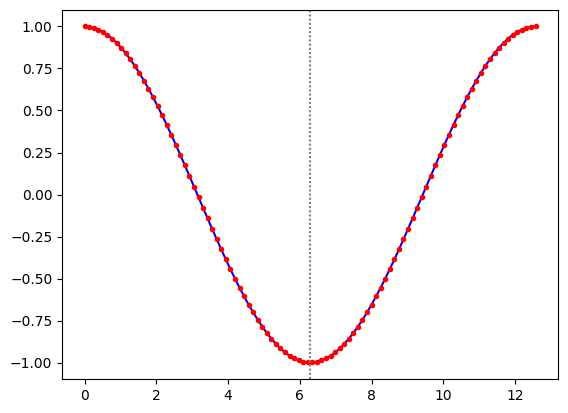

In [33]:
# initialize crx_param with 0.5 but could be any value
initial_param = (0.5,)

param = initial_param

param_values = np.linspace(0, 4 * math.pi, 100)
results = [float(circuit(p)) for p in param_values]
reconstructed_results = [reconstruction(p) for p in param_values]

fig, ax = plt.subplots()
ax.plot(param_values, results, 'b')
ax.plot(param_values, reconstructed_results, 'r.')
ax.axvline(x=numerical_x, dashes=(True,), color='gray')